# Baseline Model

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import infostop
import pyproj
import sklearn
import pickle

sys.path.append('./src')
from data_utils import *
clear_output(wait=False)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Load Train, validation and test data

In [3]:
user_train, user_val, user_test = train, val, test = train_test_data_split()

In [4]:
seq_cutoff_speed = 45
seq_cutoff_time = 60
filter_seq = 5

In [5]:
data_train = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True, load_GPS = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_train]).reset_index(drop=True)
data_val = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True, load_GPS = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_val]).reset_index(drop=True)
data_test = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True, load_GPS = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_test]).reset_index(drop=True)

In [6]:
data_train = data_train[data_train['segment_ix'] >= filter_seq]
data_val = data_val[data_val['segment_ix'] >= filter_seq]
data_test = data_test[data_test['segment_ix'] >= filter_seq]

### Visualise trajectory segmentation

In [7]:
plot_filtered(data_train[(data_train['segment_ix'] >= filter_seq)], 'speed')

### Visualise trajectory on map

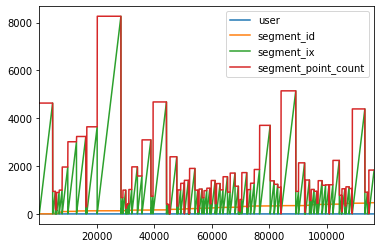

In [8]:
data_val[['user','segment_id','segment_ix','segment_point_count']].plot()

## Infostop baseline

Segmentation is not strictly needed for the Baseline model, but in order to ensure the datesets accross all three models are the same we still perform it here, and purge all points that would otherwise been purged to build the sequences.

In [9]:
labels = infostop.label_trace(data_val[['lon', 'lat']].values)

/home/valse/valse_data/anaconda3/envs/torchGPU/lib/python3.7/site-packages/infostop/detect.py:183: RuntimeWarning: invalid value encountered in less
  edges = np.column_stack(np.where(D<r2))


In [10]:
pred = np.zeros_like(labels)
pred[labels >= 0] = 1

In [11]:
print(classification_report(data_val['label'], pred, target_names = ['Motion','Stop']))

              precision    recall  f1-score   support

      Motion       0.73      0.58      0.65     43225
        Stop       0.78      0.87      0.82     72339

    accuracy                           0.76    115564
   macro avg       0.75      0.73      0.74    115564
weighted avg       0.76      0.76      0.76    115564



In [12]:
labels = infostop.label_trace(data_test[['lat', 'lon']].values)

In [13]:
pred = np.zeros_like(labels)
pred[labels >= 0] = 1

In [14]:
print(classification_report(data_test['label'], pred, target_names = ['Motion','Stop']))

              precision    recall  f1-score   support

      Motion       0.76      0.67      0.72     42456
        Stop       0.89      0.93      0.91    122886

    accuracy                           0.86    165342
   macro avg       0.83      0.80      0.81    165342
weighted avg       0.86      0.86      0.86    165342



### Setup machine learning baselines
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [17]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
    RandomForestClassifier(n_estimators=100, random_state=0, class_weight="balanced"),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

Loading BokehJS ...

### Load training and test set which are rearranged in order to present a segments of 5 points with distance between points and bearing rate

In [18]:
#X_tr, Y_tr, X_te, Y_te = rearrange_features_in_sequence(0, load=True)
X_tr, Y_tr = rearrange_features_in_sequence(pd.concat([data_train,data_val]).reset_index(drop=True), train=True)
X_te, Y_te = rearrange_features_in_sequence(data_test, test=True)

### Standardize input

In [19]:
X_tr = StandardScaler().fit_transform(X_tr)
X_te = StandardScaler().fit_transform(X_te)

### Run classifiers

In [20]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_tr, Y_tr)
    Y_pred = clf.predict(X_te)
    print('REPORT: '+name)
    print(classification_report(Y_te, Y_pred, target_names=['Motion','Stop']))

REPORT: Nearest Neighbors
              precision    recall  f1-score   support

      Motion       0.42      0.71      0.53     42456
        Stop       0.87      0.65      0.75    122886

    accuracy                           0.67    165342
   macro avg       0.64      0.68      0.64    165342
weighted avg       0.75      0.67      0.69    165342

REPORT: Decision Tree
              precision    recall  f1-score   support

      Motion       0.86      0.72      0.79     42456
        Stop       0.91      0.96      0.93    122886

    accuracy                           0.90    165342
   macro avg       0.89      0.84      0.86    165342
weighted avg       0.90      0.90      0.90    165342

REPORT: Random Forest
              precision    recall  f1-score   support

      Motion       0.92      0.68      0.78     42456
        Stop       0.90      0.98      0.94    122886

    accuracy                           0.90    165342
   macro avg       0.91      0.83      0.86    165342
weig